## 1. Setup

In [1]:
import cv2 as cv
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import skimage
import sys
import tensorflow as tf

Using TensorFlow backend.


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

print(f'sys.version: {sys.version}')
print(f'cv.version: {cv.__version__}')
print(f'keras.version: {keras.__version__}')
print(f'np.version: {np.__version__}')
print(f'skimage.version: {skimage.__version__}')
print(f'tf.version: {tf.__version__}')

sys.version: 3.6.7 |Anaconda, Inc.| (default, Oct 23 2018, 19:16:44) 
[GCC 7.3.0]
cv.version: 3.4.2
keras.version: 2.2.4
np.version: 1.16.2
skimage.version: 0.14.2
tf.version: 1.11.0


## 2. Datasets

### 2.1 VGG Cells Dataset

In [3]:
DATASET_PATH = '../../datasets/vgg_cells'
IMG_PATH = f'{DATASET_PATH}/images'
GT_DOTS_PATH = f'{DATASET_PATH}/gt_dots'
GT_DENSITY_MAPS_PATH = f'{DATASET_PATH}/gt_density_maps'

In [4]:
!rm -rf $GT_DENSITY_MAPS_PATH
!mkdir $GT_DENSITY_MAPS_PATH

In [5]:
print(DATASET_PATH)
print(os.listdir(DATASET_PATH))

../../datasets/vgg_cells
['gt_density_maps', 'gt_dots', 'images']


In [6]:
img_names = sorted(os.listdir(IMG_PATH))
NUM_IMAGES = len(img_names)
print(IMG_PATH)
print(f'{NUM_IMAGES} images')
print(img_names[:5])

../../datasets/vgg_cells/images
200 images
['001cell.png', '002cell.png', '003cell.png', '004cell.png', '005cell.png']


In [7]:
gt_dots_names = sorted(os.listdir(GT_DOTS_PATH))
print(GT_DOTS_PATH)
print(gt_dots_names[:5])

../../datasets/vgg_cells/gt_dots
['001dots.png', '002dots.png', '003dots.png', '004dots.png', '005dots.png']


#### Load images

In [8]:
images = []
gt_dots = []

for img_name, gt_dots_name in zip(img_names, gt_dots_names):
    img_path = f'{IMG_PATH}/{img_name}'
    gt_dots_path = f'{GT_DOTS_PATH}/{gt_dots_name}'
    
    img = skimage.io.imread(img_path) / 255.
    gt_dots_mask = skimage.io.imread(gt_dots_path) / 255.
    gt_dots_mask = gt_dots_mask[:,:,0]
    
    images.append(img)
    gt_dots.append(gt_dots_mask)
    
print(len(images), images[0].shape, images[0].dtype, images[0].min(), images[0].max())
print(len(gt_dots), gt_dots[0].shape, gt_dots[0].dtype, gt_dots[0].min(), gt_dots[0].max())

200 (256, 256, 3) float64 0.0 0.9882352941176471
200 (256, 256) float64 0.0 1.0


#### Play with skimage.filters.gaussian
Remember: kernel_size = truncate * sigma + 1  
Default sigma = 1  
Default truncate = 4.0

In [9]:
a = np.zeros((7, 7))
a[3, 3] = 1

b = skimage.filters.gaussian(a, sigma=1, mode='reflect', truncate=2)

print('a\n', a)
print('b\n', b)
print('b.sum(axis=0)\n', b.sum(axis=0))
print('b.sum()\n', b.sum())

a
 [[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
b
 [[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.00296902 0.01330621 0.02193823 0.01330621 0.00296902
  0.        ]
 [0.         0.01330621 0.0596343  0.09832033 0.0596343  0.01330621
  0.        ]
 [0.         0.02193823 0.09832033 0.16210282 0.09832033 0.02193823
  0.        ]
 [0.         0.01330621 0.0596343  0.09832033 0.0596343  0.01330621
  0.        ]
 [0.         0.00296902 0.01330621 0.02193823 0.01330621 0.00296902
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
b.sum(axis=0)
 [0.         0.05448868 0.24420134 0.40261995 0.24420134 0.05448868
 0.        ]
b.sum()
 1.0


#### Create density maps
Color maps: https://matplotlib.org/examples/color/colormaps_reference.html

In [10]:
SIGMA = 5

In [11]:
def gaussian_smoothing(gt_dots, sigma):
    gt_density_maps = np.zeros((len(gt_dots), *gt_dots[0].shape))
    
    for i in range(len(images)):
        gt_density_maps[i] = skimage.filters.gaussian(gt_dots[i],
                                                      sigma=sigma,
                                                      mode='reflect')
    
    return gt_density_maps

In [12]:
gt_density_maps = gaussian_smoothing(gt_dots, sigma=SIGMA)

In [13]:
print('density_maps')
print(gt_density_maps.shape, gt_density_maps.dtype,
      gt_density_maps.min(), gt_density_maps.max())
print('count:', gt_density_maps.sum())

print('\ndots')
print('count: ', np.sum([dots.sum() for dots in gt_dots]))

density_maps
(200, 256, 256) float64 0.0 0.038754667218472025
count: 35192.00000000003

dots
count:  35192.0


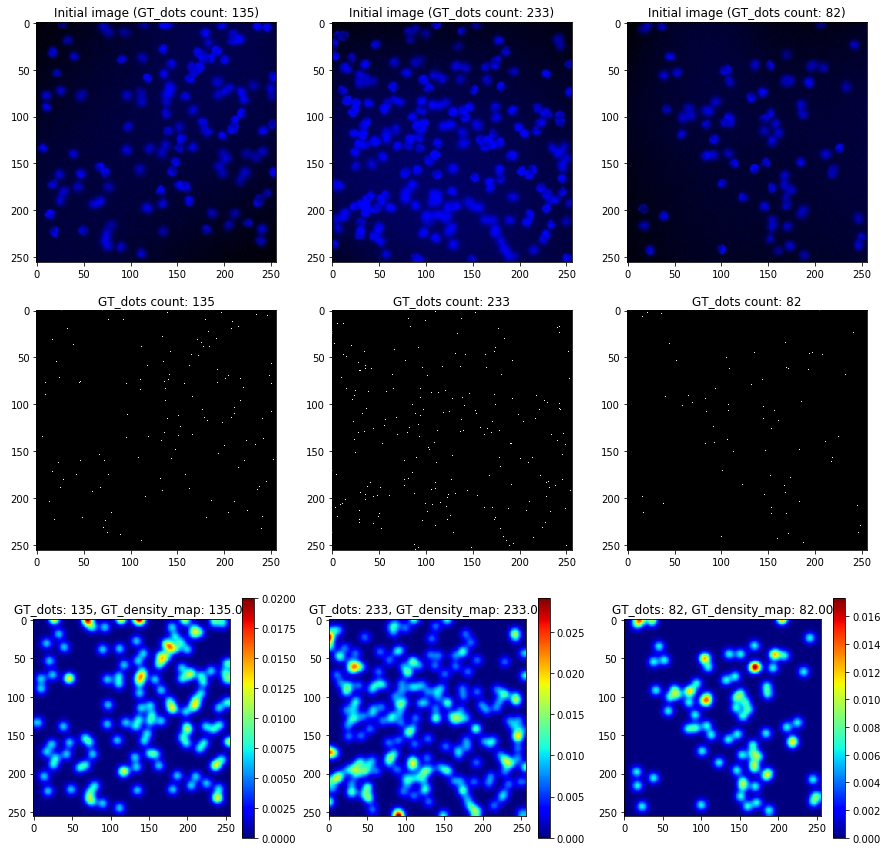

In [14]:
NUM_PLOTS = 3
plt.figure(figsize=(15, 15))
plt.title('VGG Cells Dataset')

for i in range(NUM_PLOTS):
    count = gt_dots[i].sum().astype(np.int)
    
    plt.subplot(3, NUM_PLOTS, i + 1)
    plt.title(f'Initial image (GT_dots count: {count})')
    plt.imshow(images[i])
    
    plt.subplot(3, NUM_PLOTS, NUM_PLOTS + i + 1)
    plt.title(f'GT_dots count: {count}')
    plt.imshow(gt_dots[i], cmap='gray')
    
    plt.subplot(3, NUM_PLOTS, 2 * NUM_PLOTS + i + 1)
    plt.title(f'GT_dots: {count}, GT_density_map: {gt_density_maps[i].sum():.2f}')
    plt.imshow(gt_density_maps[i], cmap='jet')
    plt.colorbar()

#### Save density maps

In [15]:
gt_density_maps_names = [f'{img_name[:3]}density' for img_name in img_names]
print(gt_density_maps_names[:5])

['001density', '002density', '003density', '004density', '005density']


In [16]:
def save_np_arrays(images, img_names, save_path):
    for img, img_name in zip(images, img_names):
        np.save(f'{save_path}/{img_name}', img)

save_np_arrays(gt_density_maps, gt_density_maps_names, GT_DENSITY_MAPS_PATH)

#### Load density maps for testing

In [17]:
def load_np_arrays(path):
    images = []
    img_names = sorted(os.listdir(path))
    for img_name in img_names:
        img = np.load(f'{path}/{img_name}')
        images.append(img)
    
    return np.array(images)

density_maps_test = load_np_arrays(GT_DENSITY_MAPS_PATH)

(200, 256, 256) float64 0.0 0.038754667218472025


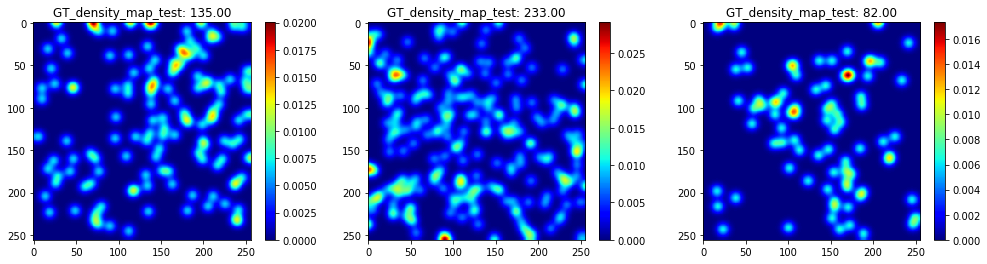

In [18]:
print(density_maps_test.shape, density_maps_test.dtype,
      density_maps_test.min(), density_maps_test.max())

plt.figure(figsize=(17, 4))
for i in range(NUM_PLOTS):
    plt.subplot(1, NUM_PLOTS, i + 1)
    plt.title(f'GT_density_map_test: {density_maps_test[i].sum():.2f}')
    plt.imshow(density_maps_test[i], cmap='jet')
    plt.colorbar()